In [83]:
from subprocess import call
from functools import partial
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import special 
from scipy.optimize import curve_fit
import scienceplots
#plt.style.use(['notebook', 'science'])

call(['gfortran', 'spin_chain.f90', '-O3', '-llapack', '-o', 'spin_chain'])
call(['gfortran', 'correl.f90', '-O3', '-lblas', '-llapack', '-o', 'correl'])

0

In [84]:
def f(x, J):
    return 2 * x[-1] / np.pi * J * np.sin(np.pi * x[:-1]/x[-1])

def S0(a, x, J):
    return 1/12*(1+1/a) * np.log(f(x, J))

def S1(a, x, J):
    if a < 1:
        return 0
    if np.isclose(a, 1):
        mu = -1/4
    else:
        mu = 2**(1-2/a)/(1-a) * special.gamma(.5+.5/a) / special.gamma(.5-.5/a)
    return mu * -(-1)**np.arange(len(x)-1) * f(x, J)**(-1/a)

In [85]:
def s2(x, a):
    if np.isclose(x, 0.) or np.isclose(x, 1.):
        return 0.
    if np.isclose(a, 1):
        return - x * np.log(x) - (1 - x) * np.log(1 - x)
    return np.log(x**a + (1 - x)**a) / (1 - a) 

def Renyi(nu, a):
    return [np.sum([s2(pi, a) for pi in p]) for p in nu.T]

In [86]:
class SpinChain:
    def __init__(self, N, J, B):
        self.N = N
        self.J = J
        self.B = B

    def conf_length(self, x):
        self.x = x

    def diagonalise(self):
        df = pd.DataFrame([self.J, self.B])
        df.to_csv('spin_chain.dat', sep=' ', header=False, index=False)
        call(['./spin_chain', 'spin_chain.dat',  f'{self.N}'])
        self.Phi = pd.read_csv('spin_chain_data/eigenvectors.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
        self.E, self.w, self.g = pd.read_csv('spin_chain_data/poly_data.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
        self.P = pd.read_csv('spin_chain_data/polynomials.dat', sep=' ', header=None, dtype=np.float64).to_numpy()

    def filling(self, M):
        self.M = M
        df = pd.DataFrame(self.Phi)
        df.to_csv('spin_chain_data/eigenvectors.dat', sep=' ', header=False, index=False)
        call(['./correl',  f'{self.N}', f'{M}'])
        self.C = pd.read_csv('correl_data/correl.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
        self.nu = pd.read_csv('correl_data/eigvals.dat', sep=' ', header=None, dtype=np.float64).to_numpy()
    
    def S(self, a=1):
        return Renyi(self.nu, a)
        


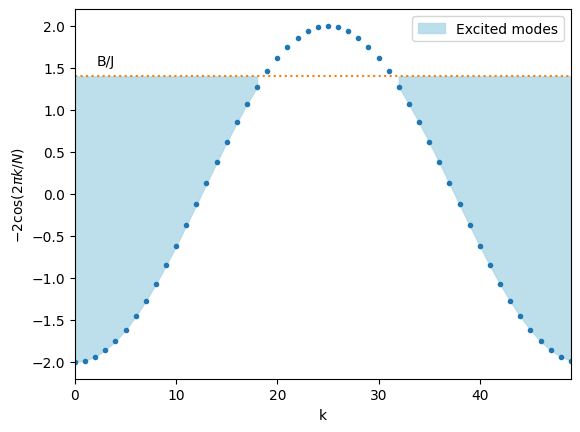

In [87]:
N = 50
J = 1
B = 1.4

kc = int(np.floor(N * np.arccos(- B / (2*J)) / (2*np.pi)))
k = np.arange(0, N)
osc = - 2*np.cos(2*np.pi*k/N)
plt.plot(k, osc, '.')
plt.plot([0, N], [B/J, B/J], ':')
plt.fill_between(k[:kc+1], osc[:kc+1], B/J, color='lightblue', alpha=.8, label='Excited modes')
plt.fill_between(k[N-kc:], osc[N-kc:], B/J, color='lightblue', alpha=.8)
plt.text(3, B/J + 0.1, 'B/J', ha='center', va='bottom') 
plt.xlabel('k')
plt.ylabel(r'$- 2\cos(2\pi k/N)$')
plt.xlim(0, N-1)
plt.ylim(-2.2, 2.2)
plt.legend()
plt.savefig('figures/homogeneous.png', bbox_inches='tight', dpi=200)

In [88]:
N = 100
M = N//2
a = 1 / (N-1)
n = np.arange(0, N-1)
B = np.zeros(N)

J = np.ones(N-1)
x = np.arange(1,N+1)/2
homogeneous = SpinChain(N, J, B)
homogeneous.conf_length(x)

h = 10; J = np.exp(- h * (n/N - .5))
s = np.arange(1,N+1)/N
x = N/2 * np.sign(s) * (np.exp(h*np.abs(s)) - 1) / h
x = x - x[-1]/2
rainbow = SpinChain(N, J, B)
rainbow.conf_length(x)

J = np.sqrt((1+n)/N * (1 - (1+n)/N))
x = N * np.arcsin(np.sqrt(np.arange(1,N+1)/N))
krawtchouk = SpinChain(N, J, B)
krawtchouk.conf_length(x)

J = np.sqrt((1+n)/N * (1 - (1+n)/N) * (1 - (1.5 + n)/N) * (.5 + n)/N)
x = N/2 * special.ellipkinc(np.arcsin(np.arange(1,N+1)/N), (1 - 1/N)**2)
lame = SpinChain(N, J, B)
lame.conf_length(x)

chains = [homogeneous, rainbow, krawtchouk, lame]

In [89]:
for chain in chains:
    chain.diagonalise()
    chain.filling(M)

Diagonalising L = 100 / 100

/tmp/ipykernel_21793/1731524524.py:5: RuntimeWarning: invalid value encountered in log
  return 1/12*(1+1/a) * np.log(f(x, J))


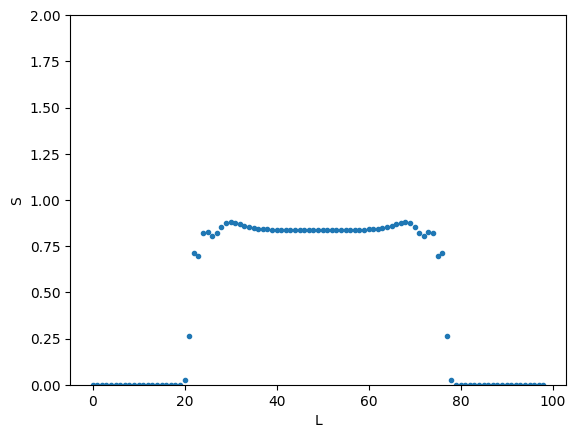

In [90]:
for chain in [chains[1]]:
    cp = np.mean(chain.S()[:-1] - S0(1, chain.x, chain.J))
    S = S0(1, chain.x, chain.J) + S1(1, chain.x, chain.J) + cp

    plt.plot(chain.S()[:-1], '.')
    plt.plot(S, lw = 1)
    plt.xlabel('L')
    plt.ylabel('S')
    plt.ylim(0, 2)